In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller


In [4]:
df = pd.read_csv("cashflow_2mv3.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

In [5]:
new_df = df.groupby(df['DATE'].dt.to_period('M')).mean()
new_df.reset_index(inplace=True)
new_df.columns = ['MONTH', 'AMOUNT']

In [6]:
print(new_df)

      MONTH       AMOUNT
0   2017-01  2181.453333
1   2017-02  2168.178500
2   2017-03  2205.318696
3   2017-04  2111.688421
4   2017-05  1973.617826
..      ...          ...
76  2023-05  4147.153478
77  2023-06  4660.415455
78  2023-07  3879.907143
79  2023-08  4587.833913
80  2023-09  4692.643000

[81 rows x 2 columns]


In [9]:
new_df.head()

,MONTH,AMOUNT
0,2017-01,2181.453333
1,2017-02,2168.178500
2,2017-03,2205.318696
3,2017-04,2111.688421
4,2017-05,1973.617826


In [8]:
new_df.tail()

,MONTH,AMOUNT
76,2023-05,4147.153478
77,2023-06,4660.415455
78,2023-07,3879.907143
79,2023-08,4587.833913
80,2023-09,4692.643000


In [10]:
new_df.set_index('MONTH',inplace=True)

In [11]:
new_df.head()

,AMOUNT
MONTH,
2017-01,2181.453333
2017-02,2168.178500
2017-03,2205.318696
2017-04,2111.688421
2017-05,1973.617826


In [12]:
new_df.describe()


,AMOUNT
count,81.000000
mean,2755.132657
std,926.135518
min,1483.385238
25%,2068.536522
50%,2374.307143
75%,3336.139048
max,4908.762632


<AxesSubplot:xlabel='MONTH'>

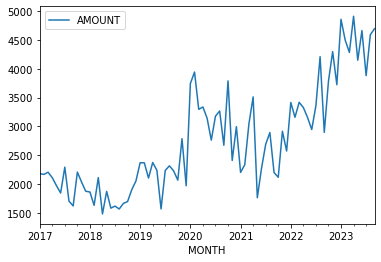

In [13]:
new_df.plot()


In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
test_result=adfuller(new_df['AMOUNT'])

In [16]:
def adfuller_test(amount):
    result=adfuller(amount)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")
    

In [17]:
adfuller_test(new_df['AMOUNT'])

ADF Test Statistic : -0.4254654966943989
p-value : 0.9057593414064424
#Lags Used : 2
Number of Observations Used : 78
Data is non-stationary 


In [18]:
#Now doing differencing
new_df['Amount First Difference'] = new_df['AMOUNT'] - new_df['AMOUNT'].shift(1)

In [19]:
new_df['AMOUNT'].shift(1)

MONTH
2017-01            NaN
2017-02    2181.453333
2017-03    2168.178500
2017-04    2205.318696
2017-05    2111.688421
              ...     
2023-05    4908.762632
2023-06    4147.153478
2023-07    4660.415455
2023-08    3879.907143
2023-09    4587.833913
Freq: M, Name: AMOUNT, Length: 81, dtype: float64

In [20]:
new_df['Seasonal First Difference']=new_df['AMOUNT']-new_df['AMOUNT'].shift(12)

In [21]:
new_df.head()

,AMOUNT,Amount First Difference,Seasonal First Difference
MONTH,,,
2017-01,2181.453333,NaN,NaN
2017-02,2168.178500,-13.274833,NaN
2017-03,2205.318696,37.140196,NaN
2017-04,2111.688421,-93.630275,NaN
2017-05,1973.617826,-138.070595,NaN


In [22]:
adfuller_test(new_df['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.944803264401294
p-value : 0.0017287761315540116
#Lags Used : 11
Number of Observations Used : 57
Data is stationary


<AxesSubplot:xlabel='MONTH'>

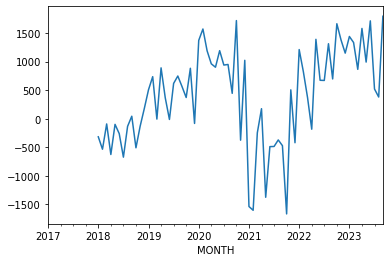

In [23]:
new_df['Seasonal First Difference'].plot()

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm


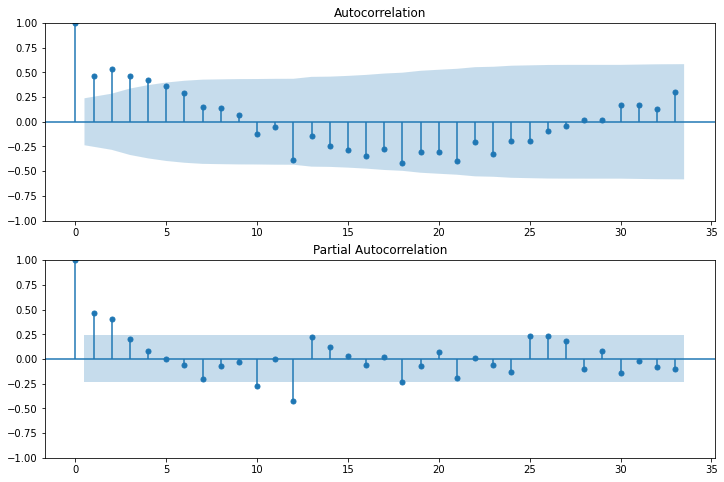

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_df['Seasonal First Difference'].iloc[13:],lags=33,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_df['Seasonal First Difference'].iloc[13:],lags=33,ax=ax2)

In [26]:
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [27]:
model=sm.tsa.statespace.SARIMAX(new_df['AMOUNT'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results = model.fit(maxiter=1000)


<AxesSubplot:xlabel='MONTH'>

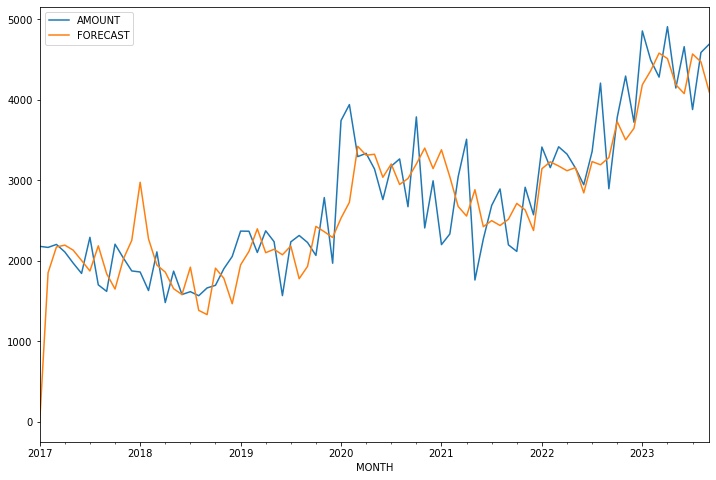

In [89]:
new_df['FORECAST'] = results.predict(start=0, end=103, dynamic=False)
new_df[['AMOUNT','FORECAST']].plot(figsize=(12,8))

In [28]:
new_df.tail()

,AMOUNT,Amount First Difference,Seasonal First Difference
MONTH,,,
2023-05,4147.153478,-761.609153,992.316660
2023-06,4660.415455,513.261976,1715.042273
2023-07,3879.907143,-780.508312,520.401143
2023-08,4587.833913,707.926770,379.803478
2023-09,4692.643000,104.809087,1796.133952


In [29]:
start_date = pd.to_datetime("2023-09") 
future_dates = [start_date + pd.DateOffset(months=x) for x in range(1, 25)]

In [30]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=new_df.columns)

In [31]:
future_df=pd.concat([new_df,future_datest_df])

<AxesSubplot:>

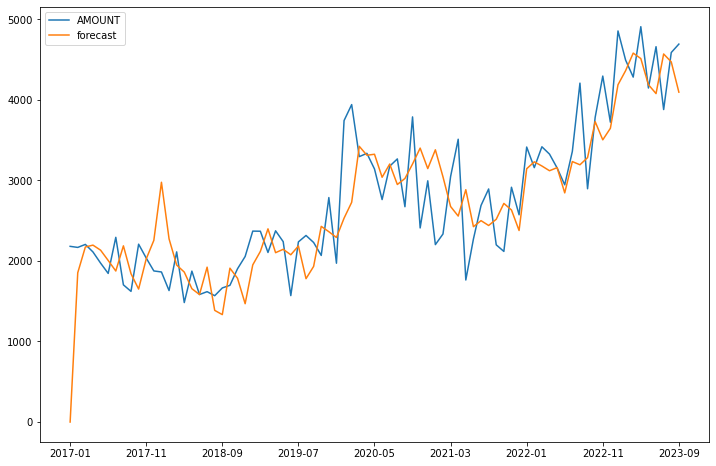

In [32]:
future_df['forecast'] = results.predict(start = 0, end = 120, dynamic= False)  
future_df[['AMOUNT', 'forecast']].plot(figsize=(12, 8)) 
